# Eyesense

Ocular Disease Intelligent Recognition (ODIR) is a structured ophthalmic database of 5,000 patients with age, color fundus photographs from left and right eyes and doctors' diagnostic keywords from doctors.

This dataset is meant to represent ‘‘real-life’’ set of patient information collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China. In these institutions, fundus images are captured by various cameras in the market, such as Canon, Zeiss and Kowa, resulting into varied image resolutions.
Annotations were labeled by trained human readers with quality control management. They classify patient into eight labels including:

-Normal (N),
-Diabetes (D),
-Glaucoma (G),
-Cataract (C),
-Age related Macular Degeneration (A),
-Hypertension (H),
-Pathological Myopia (M),
-Other diseases/abnormalities (O)

In [1]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
import os
import matplotlib.pyplot as plt

2025-03-14 18:50:20.999856: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-14 18:50:21.322042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741978221.441647   88204 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741978221.481328   88204 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1741978221.739983   88204 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
df = pd.read_csv("raw_data/full_df.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

# Preprocess images

In [4]:
def decode_img(path, file_name):
    '''
    path: OS PATH
    file_name: string
    Transform a jpg file into a tensor that represents the image
    '''
    image_path = os.path.join(path, file_name)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)  # Decode the image  
    return image


In [5]:
preproc_path = "raw_data/preprocessed_images"  #This is the path in my computer. 

img_list_preproc = os.listdir(preproc_path)
#We will create a dict in which the key is the file name and the value is the correspondent tensor image
preproc_img_dict = {file: decode_img(preproc_path, file) for file in img_list_preproc}
#df['images'] = df['filename'].apply(lambda x: decode_img(preproc_path, x))


W0000 00:00:1741978227.668226   88204 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
preproc_img_dict[img_list_preproc[0]].shape

TensorShape([512, 512, 3])

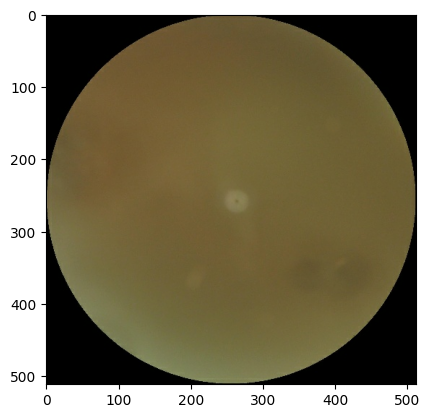

In [7]:
#Checking the image
plt.imshow(preproc_img_dict[img_list_preproc[0]]);

We need to check if all images have the same size 512x512

In [8]:
shape_sizes = [preproc_img_dict[img].shape[0]*preproc_img_dict[img].shape[1] for img in img_list_preproc]
mean_size = sum(shape_sizes)/len(shape_sizes)
#Checking the null dispersion
sum( [(size*size - mean_size**2 ) for size in shape_sizes]) == 0

True

We will need to resize the images. I think it is a good idea to learn how to use batches.

In [9]:
# Resize the image
def resize_images(image, height=128, width=128):
    """
    image: tensor
    weight: int
    width: int
    """
    resized_image = tf.image.resize(image, [height, width])
    # Optional: Cast to integer for saving or display
    # resized_image = tf.cast(resized_image, tf.uint8)
    return resized_image

To avoid problems with memory, we can resize the image. 

In [10]:
df['image_tensor'] = df['filename'].apply(lambda x: preproc_img_dict[x])

In [11]:
X = df['image_tensor'].apply(lambda x: resize_images(x)).values
y = df['target']

We can also try a batch of images. 

In [12]:
train_size = 2000  # We can try to increase or decrease this value 
test_size  = 400
#assert(train_size + test_size == len(X))  #  Use this for all dataset


In [13]:
X_list = X.tolist()
X_train = tf.stack(X_list[0:train_size])

In [14]:
import ast

y_list = [ast.literal_eval(string) for string in y]
y_train = tf.stack(y_list[0:train_size])

In [15]:
X_test = tf.stack( X_list[train_size:train_size+test_size] )
y_test = tf.stack( y_list[train_size:train_size+test_size] )

In [16]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2000, 128, 128, 3)
(2000, 8)
(400, 128, 128, 3)
(400, 8)


# Normalization

In [17]:
X_train_normalized = X_train/255
X_test_normalized = y_test/255

In [18]:
X_train_normalized.shape

TensorShape([2000, 128, 128, 3])

In [19]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Model

In [20]:
from tensorflow.keras import layers
from tensorflow.keras import models


def initialize_model():

    model = models.Sequential()

    ### First Convolution & MaxPooling
    model.add(layers.Conv2D(16, (4,4), input_shape=(128,128,3), padding='same', activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(4,4)) )
    ### Second Convolution & MaxPooling
    model.add(layers.Conv2D(32, (4,4), padding='same', activation='relu') )
    model.add(layers.MaxPool2D(pool_size=(4,4)))
    
    ### Flattening
    # YOUR CODE HERE
    model.add(layers.Flatten())
    
    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(layers.Dense(50, activation='relu'))
  
    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    model.add(layers.Dense(8, activation="softmax"))
    
    ### Model compilation
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'recall']) 
    
    return model

In [21]:
model = initialize_model()
model.summary()

/home/george/.pyenv/versions/3.10.6/envs/eyesense/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │       102,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           408 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,866 (436.98 KB)

 Trainable params: 111,866 (436.98 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=20, restore_best_weights=True)

In [23]:
history = model.fit(
    X_train,
    y_train,
    validation_split = 0.2,
    epochs = 50,
    batch_size = 16, 
    verbose = 1
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.1524 - loss: 10.4516 - recall: 0.0535 - val_accuracy: 0.0000e+00 - val_loss: 2.0369 - val_recall: 0.0000e+00
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2442 - loss: 2.0547 - recall: 0.0000e+00 - val_accuracy: 0.9875 - val_loss: 1.9676 - val_recall: 0.0000e+00
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2186 - loss: 2.0319 - recall: 0.0000e+00 - val_accuracy: 0.9975 - val_loss: 1.9033 - val_recall: 0.0000e+00
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2538 - loss: 2.0055 - recall: 0.0000e+00 - val_accuracy: 0.9975 - val_loss: 1.8426 - val_recall: 0.0000e+00
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2598 - loss: 1.9853 - recall: 0.0012 - val_accuracy: 0.9975 - val_loss: 1.7919 - val_recall: 0.0000e+00
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2299 - loss: 1.9751 - recall: 0.0039 - val_accuracy: 0.0000e+

In [24]:
results = model.evaluate(X_test, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9921 - loss: 1.5540 - recall: 0.0000e+00  


In [25]:
import matplotlib.pyplot as plt

def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.autoscale()
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.autoscale()
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

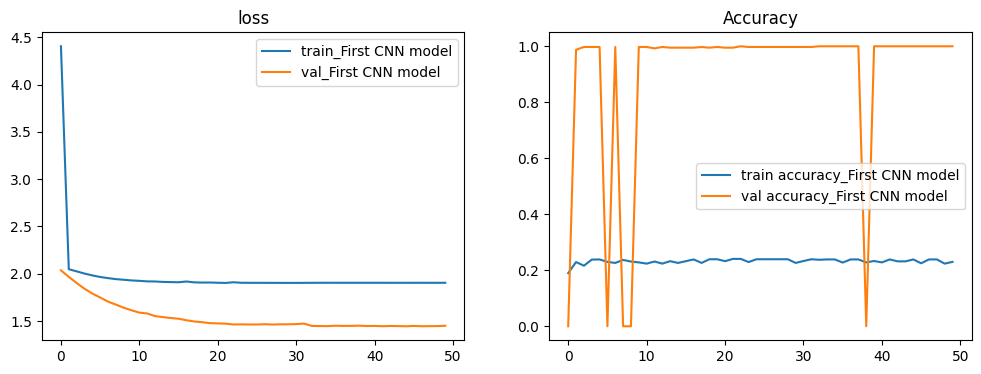

In [26]:
plot_history(history, exp_name= 'First CNN model');